# III. Transfer Learning

In [1]:
# To do transfer learning, one crucial question is:
# which model to use as base model ?

# Here I'll use efficientNet as it's perfomance matches SOTA models
# while requiring about 10x fewer parameters.

# There are quite a few flavors of the EfficientNet models 
# (EfficientNetB0, EfficientNetB1, …… EfficientB7) and they 
# differ slightly in architecture (i.e. network depth, width) 
# and resource limitations. Each of these models expects images 
# in a particular resolutions. Given we are working with 224x224 
# resolution images, we will go with EfficientNetB0.

# 1. Import libraires and set variables

In [2]:
# import libraries

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import numpy as np
import shutil
import os

In [3]:
# Set variables

ORIG_INPUT_DATASET = "House_Room_Dataset/Bedroom"
TRAIN = "training"
VAL = "evaluation"
TEST = "testing"
BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"]

In [4]:
# Reading labels from the txt file
with open("labels.txt", 'r') as f:
      manual_labels = f.read()
# Extracting individual labels into a list
labels = [i for i in manual_labels]
len(labels)

451

In [5]:
from collections import Counter
print(Counter(labels).keys()) 
print(Counter(labels).values())

dict_keys(['O', 'M'])
dict_values([271, 180])


In [6]:
# sorting files in the order they appear
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))
# checking to see the correct file order
files[:5]

['bed_1.jpg', 'bed_2.jpg', 'bed_3.jpg', 'bed_4.jpg', 'bed_8.jpg']

In [7]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], 
                 labels, 
                 stratify=labels, 
                 train_size=0.90)
# further splitting of train set into train and val sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)
# Checking the size of train, test, eval
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

In [4]:
trainPath = os.path.join(BASE_PATH, TRAIN)
valPath = os.path.join(BASE_PATH, VAL)
testPath = os.path.join(BASE_PATH, TEST)
totalTrain = len(os.listdir(trainPath+'/M')) + len(os.listdir(trainPath+'/O'))
totalVal = len(os.listdir(valPath+'/M')) + len(os.listdir(valPath+'/O'))
totalTest = len(os.listdir(testPath+'/M')) + len(os.listdir(testPath+'/O'))
print(totalTrain, totalTest, totalVal)

270 91 90


# 2. Training data augmentation

In [5]:

trainAug = ImageDataGenerator(rotation_range=90,
                              zoom_range=[0.5, 1.0],
                              width_shift_range=0.3,
                              height_shift_range=0.25,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              brightness_range=[0.2, 1.0])

valAug = ImageDataGenerator()
testAug = ImageDataGenerator()

In [6]:
# Create training batches whilst creating augmented images on the fly
trainGen = trainAug.flow_from_directory(directory=trainPath,
                                        target_size=(224,224),
                                        shuffle=True)

# Create val batches 
valGen = valAug.flow_from_directory(directory=valPath,
                                    target_size=(224,224),
                                    shuffle=True)

testGen = testAug.flow_from_directory(directory=testPath,
                                      target_size=(224,224),
                                      shuffle=False)

Found 270 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


# 3. Load model, freeze layers and add new classifier and train

In [7]:
# Let load EfficientNetB0 base model using imagenet weights

# we'll set the "include_top" parameter to "False" to remove 
# the Dense layer at the top of EfficientNet network.

# We'll also set the "pooling" paramter to "avg" to set our 
# new classifier to be a global pooling layer 
# (instead of a stack of dense layers). 

baseModel = EfficientNetB0(
            weights="imagenet",
            include_top=False, # make sure top layer is not included
            input_tensor=Input(shape=(224, 224, 3)),
            pooling="avg")


# Let freeze the weights by setting trainable for each layer as False:
for layer in baseModel.layers:
    layer.trainable = False


# Now we'll add a new classifier on top of the base model for our two classes
# classifier task. we'll allso add a Dropout and a BatchNormalization layers
# for regularization.

x = baseModel.output
Layer_1 = BatchNormalization()(x)
Layer_2 = Dropout(0.5)(Layer_1)
output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
model = Model(inputs = baseModel.input, outputs = output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [8]:
# compile the model
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()]
              )

In [9]:
# To ensure that the model does not train for more epochs than necessary, 
# we'll implement the "EarlyStopping" method. This is done by monitoring
# "val_loss" and as soon as there are no further improvements 
# i.e. it can’t be minimized further, training is stopped.

# We'll also implement the "ModelCheckpoint" method to save the best model
# at the given file path — in our case "feature_extraction.h5". 
# We are again going to monitor validation loss and save the best model
# from all epochs.

# implementing early stopping
es = EarlyStopping(
     monitor='val_loss',  #metric to monitor
     mode='min',  # whether to min or max the metric monitored
     patience=10, # epochs to wait before declaring stopped training
     verbose=1  # output epoch when training was stopped
     )
# implementing model checkpoint
mc = ModelCheckpoint(
      'feature_extraction.h5',
       monitor='val_loss',
       mode='min',
       verbose=1, # display epoch+accuracy everytime model is saved
       save_best_only=True
      )

In [10]:
# Training the model
hist = model.fit(x=trainGen,
                 epochs=25,
                 verbose=2,
                 validation_data=valGen,
                 steps_per_epoch=totalTrain // BATCH_SIZE,
                 callbacks=[es, mc])

Epoch 1/25

Epoch 00001: val_loss improved from inf to 0.72862, saving model to feature_extraction.h5


C:\Users\silve\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


8/8 - 23s - loss: 1.0327 - auc: 0.5122 - val_loss: 0.7286 - val_auc: 0.4235 - 23s/epoch - 3s/step
Epoch 2/25

Epoch 00002: val_loss improved from 0.72862 to 0.70556, saving model to feature_extraction.h5
8/8 - 18s - loss: 0.9140 - auc: 0.6214 - val_loss: 0.7056 - val_auc: 0.5162 - 18s/epoch - 2s/step
Epoch 3/25

Epoch 00003: val_loss improved from 0.70556 to 0.68411, saving model to feature_extraction.h5
8/8 - 18s - loss: 0.8520 - auc: 0.6626 - val_loss: 0.6841 - val_auc: 0.6068 - 18s/epoch - 2s/step
Epoch 4/25

Epoch 00004: val_loss improved from 0.68411 to 0.66842, saving model to feature_extraction.h5
8/8 - 16s - loss: 0.8361 - auc: 0.6607 - val_loss: 0.6684 - val_auc: 0.6477 - 16s/epoch - 2s/step
Epoch 5/25

Epoch 00005: val_loss improved from 0.66842 to 0.66075, saving model to feature_extraction.h5
8/8 - 16s - loss: 0.8003 - auc: 0.7089 - val_loss: 0.6607 - val_auc: 0.6616 - 16s/epoch - 2s/step
Epoch 6/25

Epoch 00006: val_loss improved from 0.66075 to 0.65248, saving model to fe

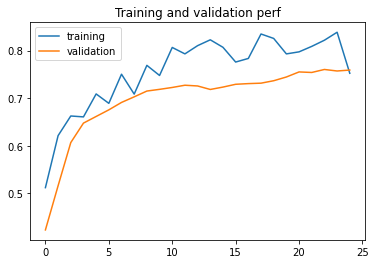

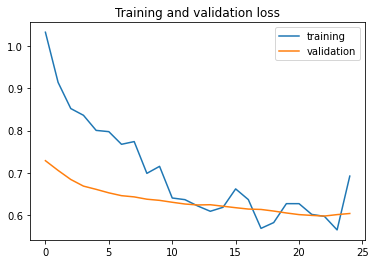

<Figure size 432x288 with 0 Axes>

In [11]:
from usefull_functions import plot_training_curve

plot_training_curve(history=hist, training=("auc", "loss"), validation=("val_auc", "val_loss"))

In [ ]:
# From these plots we can see that our model learned well as the 
# performances are converging. We can also see that there is no
# overfitting. This means the model is ready for fine tuning.

No. of test images 91
{'M': 0, 'O': 1}


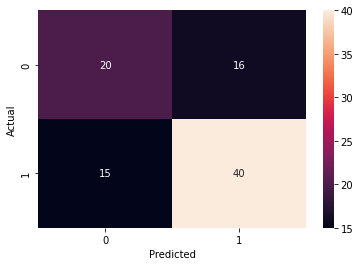

In [12]:
# Before moving to fine-tuning step, let's have a look to the 
# confusion matrix.

testGen.reset()
predIdxs = model.predict(
             x=testGen,
             steps=(totalTest // BATCH_SIZE) + 1
            )
predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)
cm = confusion_matrix(testGen.classes, predIdxs)
heatmap = sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Model fine-tuning

In [13]:
# To fine tune a model, one begins by unfreezing some layers.
# The depth at which to unfreeze depends on the amount of 
# data available for training. Here wil only have 270 training image
# so we'll just unfreeze the last block as layers are organized into blocks.
# This last block is named "block7d". Generally, Batchnormalization layers
# are kept frozen in the fine-tuning step, it will also be the case here.
# In total, 20 layers from the network would be candidates for unfreezing


# When compiling the model at this step, use an even smaller learning rate 
# compared to the feature extraction step. A smaller learning rate means 
# more epochs will be needed since smaller changes will be made to the 
# network weights on each update.

def fine_tune_model(model):
    # unfreeze last conv block i.e. block7a 
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    
    # check which of these are trainable and which aren't
    for layer in model.layers:
        print("{}: {}".format(layer, layer.trainable))
        
    # compile (with an even smaller learning rate)
    opt = Adam(learning_rate=1e-5)
    model.compile(
             optimizer=opt,
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.AUC()]
             )
    return model

model_fine_tuned = fine_tune_model(model)

<keras.engine.input_layer.InputLayer object at 0x000001A8CAF89220>: False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A8D7318EB0>: False
<keras.layers.preprocessing.normalization.Normalization object at 0x000001A8D739A0A0>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001A8D739A6A0>: False
<keras.layers.convolutional.Conv2D object at 0x000001A8D739AF40>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A8D74494F0>: False
<keras.layers.core.activation.Activation object at 0x000001A8D74740D0>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001A8D748D490>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A8D7474E80>: False
<keras.layers.core.activation.Activation object at 0x000001A8D74EC0A0>: False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x000001A8D74F51F0>: False
<keras.layers.core.reshape.Reshape object at 0x000001A8D74F5

In [14]:
# Because fine-tuning will also make use of the same data generators 
# i.e. trainGen,valGen, and testGen, it is important to reset them 
# so they start with the very first sample in the dataset.
trainGen.reset()
valGen.reset()
testGen.reset()

In [15]:
# Finally, let’s set the early stopping and model checkpoint 
# (notice we have increased patience to 20 as we are now going 
# to train for longer i.e. 50 epochs) and get the training started.

# implementing early stopping
es_tune = EarlyStopping(
     monitor='val_loss', 
     mode='min',  
     patience=20, 
     verbose=1)
# implementing model checkpoint
mc_tune = ModelCheckpoint(
      'fine_tuned_house.h5',
       monitor='val_loss',
       mode='min',
       verbose=1, 
       save_best_only=True)


hist = model_fine_tuned.fit(
      x=trainGen,
      steps_per_epoch=totalTrain // BATCH_SIZE,
      validation_data=valGen,
      epochs=50,
      verbose=2,
      callbacks=[es_tune, mc_tune]
     )


Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.60136, saving model to fine_tuned_house.h5


C:\Users\silve\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


8/8 - 27s - loss: 0.5073 - auc_1: 0.8687 - val_loss: 0.6014 - val_auc_1: 0.7596 - 27s/epoch - 3s/step
Epoch 2/50

Epoch 00002: val_loss improved from 0.60136 to 0.60020, saving model to fine_tuned_house.h5
8/8 - 17s - loss: 0.5466 - auc_1: 0.8451 - val_loss: 0.6002 - val_auc_1: 0.7590 - 17s/epoch - 2s/step
Epoch 3/50

Epoch 00003: val_loss improved from 0.60020 to 0.59981, saving model to fine_tuned_house.h5
8/8 - 17s - loss: 0.6058 - auc_1: 0.8057 - val_loss: 0.5998 - val_auc_1: 0.7593 - 17s/epoch - 2s/step
Epoch 4/50

Epoch 00004: val_loss improved from 0.59981 to 0.59943, saving model to fine_tuned_house.h5
8/8 - 17s - loss: 0.5698 - auc_1: 0.8312 - val_loss: 0.5994 - val_auc_1: 0.7604 - 17s/epoch - 2s/step
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.59943
8/8 - 17s - loss: 0.5979 - auc_1: 0.8125 - val_loss: 0.5997 - val_auc_1: 0.7595 - 17s/epoch - 2s/step
Epoch 6/50

Epoch 00006: val_loss improved from 0.59943 to 0.59856, saving model to fine_tuned_house.h5
8/8 - 18s -

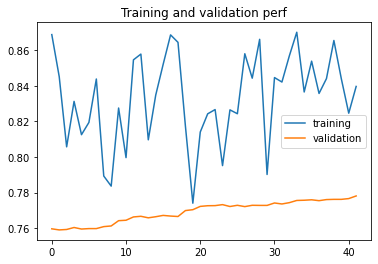

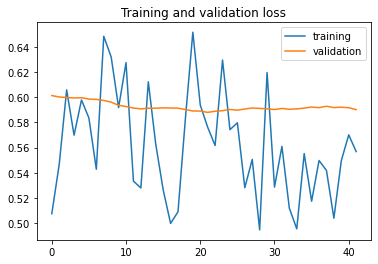

<Figure size 432x288 with 0 Axes>

In [16]:
from usefull_functions import plot_training_curve

plot_training_curve(history=hist, training=("auc_1", "loss"), validation=("val_auc_1", "val_loss"))

In [22]:
# The validation loss is not volatile and is stable at around 0.59, 
# indicating the model has not been overfitted. In general, the AUC 
# of the validation set predictions does get better with more epochs 
# but with diminishing returns. In simpler words, doesn't seem like 
# training for longer would help our case substantially.

# The fluctuations in the training curve may due to batch size or the
# learning rate but the most probable explanation may be that the network
# has reached its capacity with respect to the given dataset i.e. it can't 
# learn no more from it. This is possible since we are trying to train a 
# relatively large network (remember we have unfrozen some additional layers
# meaning more trainable parameters exist) using only 270 samples which are
# unable to provide sufficient information to learn the problem (any further).


In [23]:
# Let move to another approach : semi-supervised learning as some papers have 
# shown that training with both unlabelled and labeled datasets outperforms 
# the pipeline wherein we first pre-train with unlabelled data and then 
# fine-tune on labeled data. This would allow us to make full use of the 
# remaining images in our dataset for which it was difficult to obtain labels.

# III. Semi-supervsed Learning